[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Skrikunov/PAPR_reduction/blob/master/PAPR.ipynb)


# Imports

In [134]:
reload = [False,True][0]
if reload: 
    !lsof /dev/nvidia* | awk '{print $2}' | xargs -I {} kill {}

In [135]:
# EXTERNAL LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import yaml
from pathlib import Path
import os
import sys

# MY SCRIPTS
sys.path.append('functions/') # scripts folder
import plots
import system as syst
import qammod as qmd
import papreduce as prd
import ccdf as ccdf
import file as f

# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
    print('You are going to use GOOGLE COLAB')
except ImportError:
    IN_COLAB = False
    print('You are going to use LOCAL MACHINE')

# Add path for scripts and files directory
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    AUX_DATA_ROOT = Path("/content/drive/My Drive/PAPR reduction/Code")
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    sys.path.append(str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = ''
    
CFG_PATH = os.path.join(AUX_DATA_ROOT, 'config.yaml')
      
if torch.cuda.is_available():
    device=torch.device('cuda')
    print('You are going to use CUDA')
else:
    device=torch.device('cpu')
    print('You are going to use CPU')
    
%load_ext autoreload
%autoreload 2

You are going to use LOCAL MACHINE
You are going to use CUDA
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load system's configuration

In [136]:
# OPEN CONFIGURATION FILE
with open('config.yaml','r') as file:
    cfg = yaml.load(file, Loader=yaml.FullLoader)
    print('* Config has been read successfully:')

# edit configuration
# cfg['Fs'] = 15.36
cfg['N_UE'] = 3
# cfg['P_UE_max_min'] = 100
# cfg['N_fft'] = 300
# cfg['N_used'] = 120
# cfg['N_zero'] = 180
# cfg['N_RB'] = 10
cfg['M'] = 500
# cfg['N_SC_RB'] = 12

USE_SEED = False
if not USE_SEED:
    cfg['RNG_SEED'] = cfg['P_SEED'] = cfg['M_SEED'] = cfg['RB_SEED'] = None
else:
    cfg['RNG_SEED'], cfg['P_SEED'], cfg['M_SEED'], cfg['RB_SEED'] = 0,1,2,3
# show system's configuration
display(cfg)

# load complex and decimal modulation constellations
constellations = qmd.load_constellations(config=cfg,device=device,info=True)

# load Fourier matrix
S_sc = prd.gen_fourier_matrix(config=cfg,device=device)

# PAPR range for CCDF
PAPR_RANGE = torch.arange(0,12.2,step=0.2)

# zero shift to center spectrum
ZERO_SHIFT = cfg['N_zero']//2

CCDF_SIZE = (8,5)
PSD_SIZE = (10,6)

* Config has been read successfully:


{'Fs': 15.36,
 'N_UE': 3,
 'P_UE_max_min': 100,
 'P_TX': 100,
 'N_fft': 1024,
 'N_used': 600,
 'N_zero': 424,
 'N_RB': 50,
 'EVM_QPSK': 17.5,
 'EVM_QAM16': 12.5,
 'EVM_QAM64': 8,
 'EVM_QAM256': 3.5,
 'EVM_QAM1024': 1,
 'M': 500,
 'N_SC_RB': 12,
 'RNG_SEED': None,
 'P_SEED': None,
 'M_SEED': None,
 'RB_SEED': None}

The following constelletions have been loaded: ['QPSK', 'QAM16', 'QAM64', 'QAM256', 'QAM1024']


# Power allocation
# Modulation type allocation, EVM allocation
# Allowed noise level allocation(calculation)
# Resourse block allocation

In [137]:
PTX_allocation = syst.PTX_allocate(config=cfg,info=True)
PTX_allocation = 100*np.ones(cfg['N_UE'])/cfg['N_UE']
# PTX_allocation = np.array([17,25,33,25,0.001])

MOD_allocation,EVM_allocation = syst.MOD_allocate(config=cfg,info=True)
# MOD_allocation,EVM_allocation = ['QPSK', 'QAM16', 'QAM256'], np.array([17.5,12.5,8])
ANL_allocation,_ = syst.get_ANL_allocation(EVM_allocation,PTX_allocation,info=True)
RB_allocation = syst.RB_allocate(config=cfg,info=True)
# RB_allocation = np.array([16,16,18])

UE_IDXs = np.arange(cfg['N_UE'])
UE_ANLs = ANL_allocation
UE_SCs = [syst.GET_GROUP_SC(N_used=cfg['N_used'],UE_indexes=np.array([i]),RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT for i in UE_IDXs]

* UE power has been allocated - OK:
Max UE power can be:     98.039
Min UE power can be:      0.980
Sum UE power can be:    100.000
Current Ptx allocation: [45. 18. 37.] Sum = 100.000

* MODs have been allocated - OK:
Current MODs allocation: ['QPSK', 'QAM1024', 'QAM16']
Current EVMs allocation: [17.5  1.  12.5]

Allowed noise level allocation: [-19.91  -44.771 -22.833] dB
                                [10.104  0.577  7.217] %

* RBs have been allocated - OK:
Current RB allocation: [18 17 15] Sum = 50



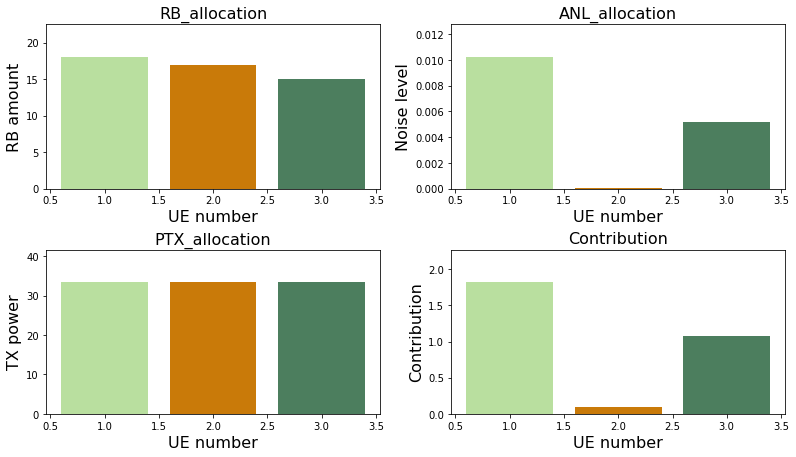

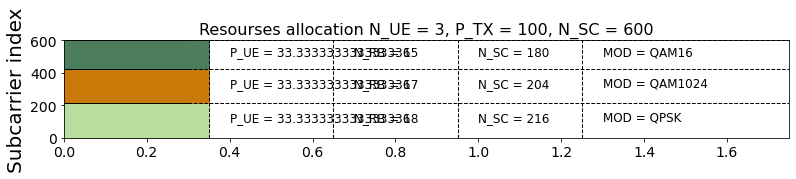

In [138]:
color_list = plots.plot_allocations(RB_allocation,PTX_allocation,ANL_allocation)
plots.plot_res_allocation(np.array(PTX_allocation),np.array(RB_allocation),MOD_allocation,color_list,cfg)

# OFDM signal generation

# Check PAPR

In [139]:
torch.cuda.ipc_collect()
torch.cuda.empty_cache()
D_points = syst.GEN_points(device,MOD_allocation,RB_allocation,cfg,info=False) # generate data points
S_t,S_f = syst.MOD_signal(D_points,device,MOD_allocation,PTX_allocation,RB_allocation,constellations,cfg,info=True) # modulate them
PAPR = syst.get_signal_PAPR(S_t) # find PAPR for each symbol
PAPR_mean0,PAPR_max0 = PAPR.mean(),PAPR.max()
max_PAPR_idx0 = torch.argmax(PAPR)
print('Initial mean PAPR is ',PAPR_mean0)
print('Initial max PAPR is ',PAPR_max0)
print('Initial max PAPR symbol index ',max_PAPR_idx0)

The signal has been generated:
Total power =              100.000
OFDM symbols:                  500
IFFT length:                 1024
Mean power in freq dommain = 19.531
Mean power in time dommain = 19.531
Initial mean PAPR is  tensor(8.6918, device='cuda:0')
Initial max PAPR is  tensor(11.1555, device='cuda:0')
Initial max PAPR symbol index  tensor(58, device='cuda:0')


# Max and min PAPR OFDM symbol

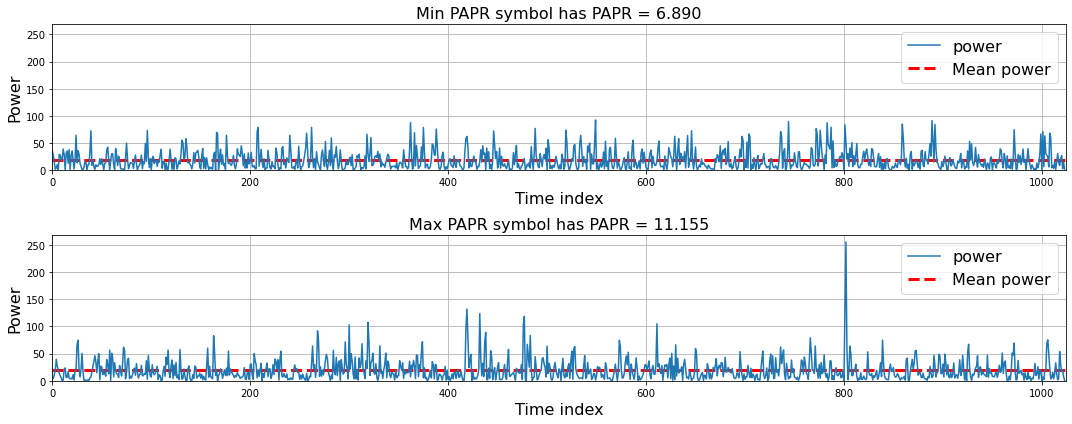

In [140]:
min_papr,max_papr = plots.find_max_min_papr_symbol(S_t,S_f,PAPR)
plots.plot_maxminpapr(min_papr,max_papr,figsize=(15,6))

# PAPR probability density function (PDF)

In [141]:
# a = []
# for i in range(1000):
#     cfg['RNG_SEED'] = i
#     torch.cuda.ipc_collect()
#     torch.cuda.empty_cache()
#     D_points = syst.GEN_points(device,MOD_allocation,RB_allocation,cfg,info=False)
#     S_t,S_f = syst.MOD_signal(D_points,device,MOD_allocation,PTX_allocation,RB_allocation,constellations,cfg,info=False)
#     PAPR,PAPR_mean0,_ = syst.get_signal_PAPR(S_t)
#     a.extend(np.copy(PAPR.cpu()))

In [142]:
# bins = 300
# plt.figure(figsize=(12,3))
# plt.title('OFDM signal PAPR PDF',fontsize=16)
# plt.xlabel('PAPR value',fontsize=16)
# plt.ylabel('Probability',fontsize=16)

# h = plt.hist(np.array(a).reshape(-1,1)[:], bins, label='Signal amplitude')
# # plt.legend(loc='upper right', prop={'size': 14})
# plt.xlim(4,12)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.show()

# th = 4

In [143]:
ue_idx = 0
peak_th = 4
print("Consider as peaks signals exceeding (of mean power): ",10**(peak_th/10))
S_t_reduced = prd.PAPR_reduce(S_t,peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg,info=True)

Consider as peaks signals exceeding (of mean power):  2.51188643150958
Pdata/Ptones before supression [-7.03 -6.07 -8.08 -7.18 -6.77 -7.22 -6.28 -6.64 -7.17 -7.45 -6.65 -6.2
 -6.95 -6.78 -6.49 -6.88 -6.48 -6.97 -6.83 -7.08 -7.22 -6.78 -6.37 -6.88
 -6.27 -7.75 -6.06 -6.78 -7.19 -6.74 -6.35 -6.57 -7.35 -6.77 -7.03 -6.62
 -6.29 -7.47 -7.55 -7.18 -6.77 -7.36 -6.91 -7.24 -6.67 -6.73 -7.19 -6.57
 -6.63 -6.5  -7.17 -6.77 -6.51 -6.8  -6.38 -7.45 -6.96 -6.92 -7.15 -6.61
 -6.28 -7.06 -6.24 -7.43 -7.09 -6.64 -6.61 -7.91 -7.33 -6.95 -7.06 -6.95
 -6.32 -6.57 -6.5  -6.78 -7.01 -6.69 -7.64 -7.   -6.59 -7.34 -6.55 -6.76
 -6.88 -6.67 -6.69 -7.45 -6.92 -6.49 -7.84 -6.08 -6.59 -6.85 -7.38 -8.14
 -6.63 -6.85 -6.14 -6.76 -7.   -6.92 -6.53 -7.03 -7.5  -7.03 -7.74 -7.05
 -6.98 -6.44 -7.56 -6.19 -6.52 -7.1  -7.37 -6.95 -7.19 -6.5  -6.21 -6.52
 -7.27 -7.   -6.   -6.83 -6.4  -6.41 -7.71 -6.86 -7.22 -6.62 -7.38 -7.14
 -7.08 -5.96 -6.79 -7.04 -7.98 -7.07 -6.22 -6.96 -7.18 -6.85 -6.46 -7.
 -7.01 -7.25 -6.85 -6.83 

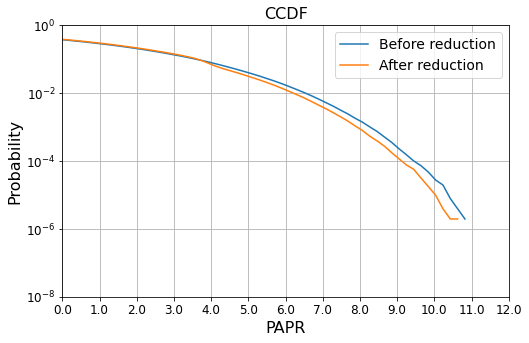

Mean PAPR before reduction: tensor(8.6918, device='cuda:0')
Mean PAPR after reduction: tensor(8.3266, device='cuda:0')
Mean PAPR has been reduced by:  tensor(0.3653, device='cuda:0') dB
Max PAPR has been reduced by:  tensor(0.3266, device='cuda:0') dB


In [144]:
LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDFs = [plots.filter_ccdf(CCDF1),plots.filter_ccdf(CCDF2)]

plots.plot_CCDF(CCDFs,LABELS,PAPR_RANGE,figsize=CCDF_SIZE)

PAPR = syst.get_signal_PAPR(S_t_reduced)
PAPR_mean1 = PAPR.mean()
print('Mean PAPR before reduction:',PAPR_mean0)
print('Mean PAPR after reduction:',PAPR_mean1)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean1,'dB')
print('Max PAPR has been reduced by: ',PAPR_max0-PAPR[max_PAPR_idx0],'dB')

# OFDM signal amplitude probability distribution

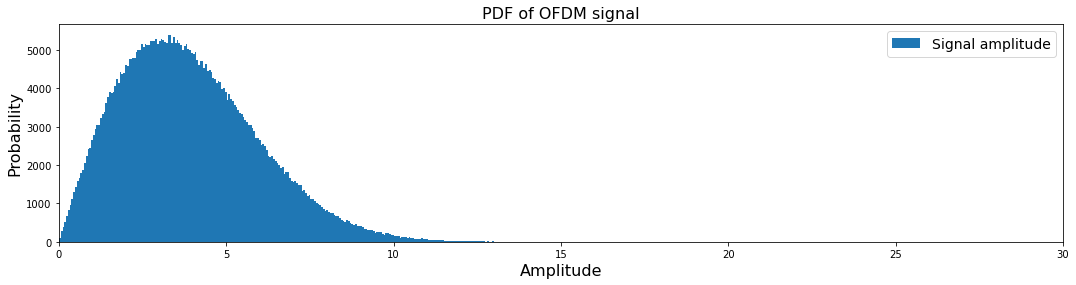

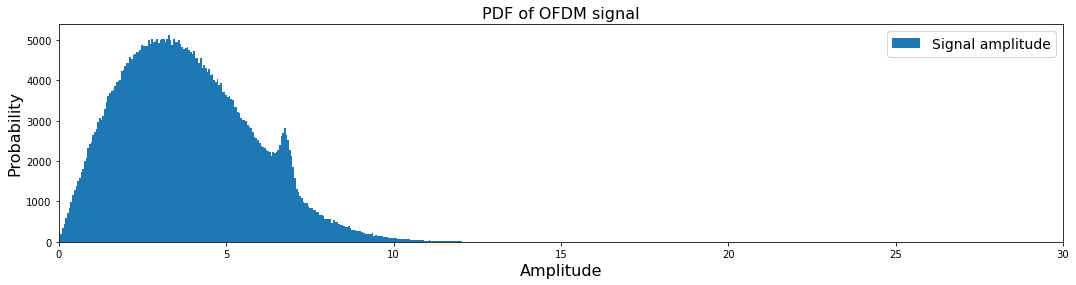

In [145]:
bins = 300
plt.figure(figsize=(18,4))
plt.title('PDF of OFDM signal',fontsize=16)
plt.xlabel('Amplitude',fontsize=16)
plt.ylabel('Probability',fontsize=16)

signal = np.array(torch.abs(S_t).cpu().reshape(-1,1))

h = plt.hist(signal, bins, label='Signal amplitude')
plt.legend(loc='upper right', prop={'size': 14})
plt.xlim(0,30)
plt.show()

bins = 300
plt.figure(figsize=(18,4))
plt.title('PDF of OFDM signal',fontsize=16)
plt.xlabel('Amplitude',fontsize=16)
plt.ylabel('Probability',fontsize=16)

signal = np.array(torch.abs(S_t_reduced).cpu().reshape(-1,1))

h = plt.hist(signal, bins, label='Signal amplitude')
plt.legend(loc='upper right', prop={'size': 14})
plt.xlim(0,30)
plt.show()

# th = 6

In [146]:
ue_idx = 1
peak_th = 6
print("Consider as peaks signals exceeding (of mean power): ",10**(peak_th/10))
S_t_reduced = prd.PAPR_reduce(S_t,peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg,info=False)

Consider as peaks signals exceeding (of mean power):  3.9810717055349722


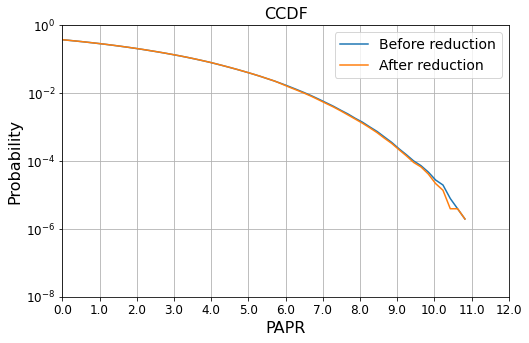

Mean PAPR before reduction: tensor(8.6918, device='cuda:0')
Mean PAPR after reduction: tensor(8.6476, device='cuda:0')
Mean PAPR has been reduced by:  tensor(0.0443, device='cuda:0') dB
Max PAPR has been reduced by:  tensor(0.0515, device='cuda:0') dB


In [147]:
LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDFs = [(CCDF1),(CCDF2)]

plots.plot_CCDF(CCDFs,LABELS,PAPR_RANGE,figsize=CCDF_SIZE)

PAPR = syst.get_signal_PAPR(S_t_reduced)
PAPR_mean1 = PAPR.mean()
print('Mean PAPR before reduction:',PAPR_mean0)
print('Mean PAPR after reduction:',PAPR_mean1)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean1,'dB')
print('Max PAPR has been reduced by: ',PAPR_max0-PAPR[max_PAPR_idx0],'dB')

# th = 8

In [148]:
ue_idx = 2
peak_th = 8
print("Consider as peaks signals exceeding (of mean power): ",10**(peak_th/10))
S_t_reduced = prd.PAPR_reduce(S_t,peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg,info=False)

Consider as peaks signals exceeding (of mean power):  6.309573444801933


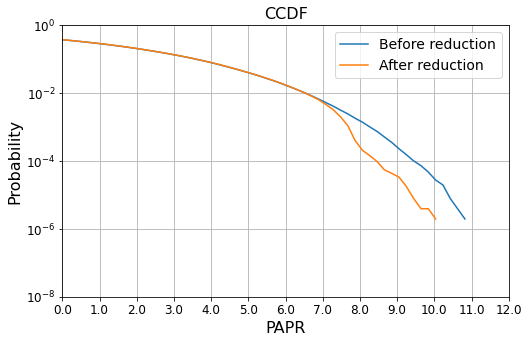

Mean PAPR before reduction: tensor(8.6918, device='cuda:0')
Mean PAPR after reduction: tensor(7.9506, device='cuda:0')
Mean PAPR has been reduced by:  tensor(0.7413, device='cuda:0') dB
Max PAPR has been reduced by:  tensor(0.9221, device='cuda:0') dB


In [149]:
LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDFs = [(CCDF1),(CCDF2)]

plots.plot_CCDF(CCDFs,LABELS,PAPR_RANGE,figsize=CCDF_SIZE)

PAPR = syst.get_signal_PAPR(S_t_reduced)
PAPR_mean1 = PAPR.mean()
print('Mean PAPR before reduction:',PAPR_mean0)
print('Mean PAPR after reduction:',PAPR_mean1)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean1,'dB')
print('Max PAPR has been reduced by: ',PAPR_max0-PAPR[max_PAPR_idx0],'dB')

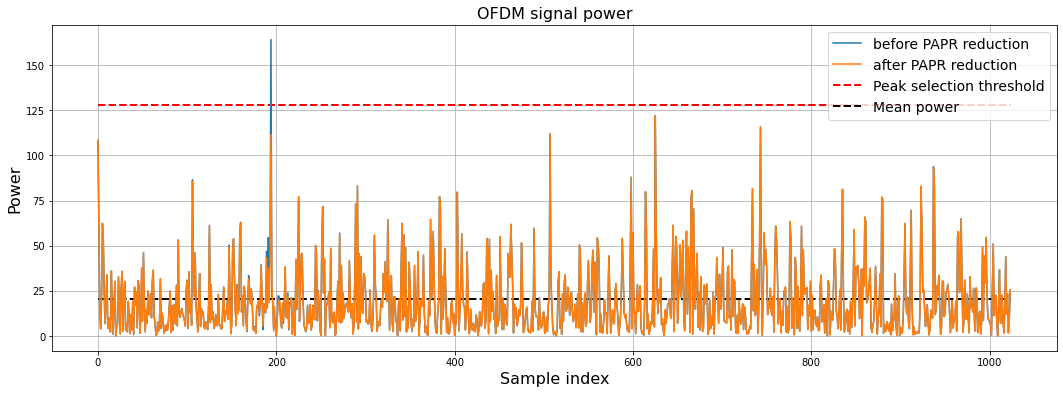

In [150]:
plt.figure(figsize=(18,6))
plt.title('OFDM signal power',fontsize=16)
plt.hlines(np.mean(np.abs(np.array(S_t[2,:].cpu()))**2)*10**(peak_th/10),0,len(S_t),'r','--',linewidth=2,label='Peak selection threshold')
plt.hlines(np.mean(np.abs(np.array(S_t[2,:].cpu()))**2),0,len(S_t),'k','--',linewidth=2,label='Mean power')

stem = [True,False][1]
if stem:
    plt.stem(np.arange(1024),abs(S_t[:,0].cpu())**2,markerfmt='',label='before PAPR reduction')
    plt.stem(np.arange(1024),abs(S_t_reduced[:,0].cpu())**2,markerfmt='',label='after PAPR reduction')
else:
    plt.plot(abs(S_t[:,0].cpu())**2,label='before PAPR reduction')
    plt.plot(abs(S_t_reduced[:,0].cpu())**2,label='after PAPR reduction')

plt.legend(loc='upper right', prop={'size': 14})
plt.xlabel('Sample index',fontsize=16)
plt.ylabel('Power',fontsize=16)
plt.grid()

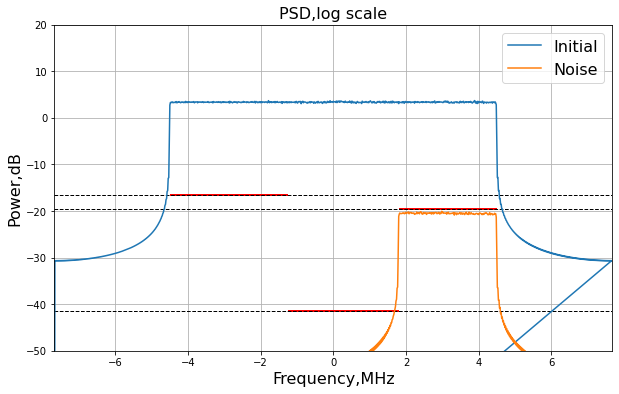

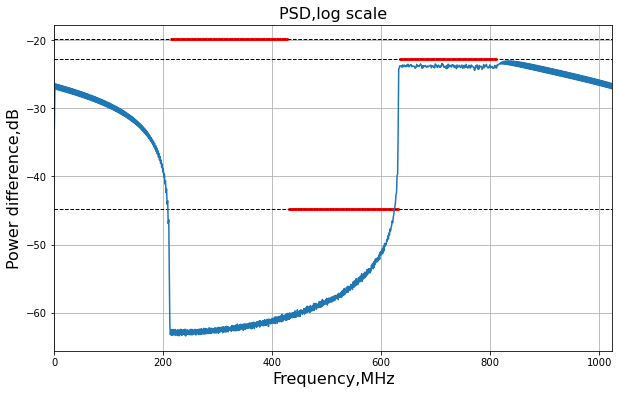

In [151]:
SIGNALS = [S_t,(S_t-S_t_reduced)]
LABELS=['Initial','Noise']
TITLE='PSD,log scale'
SC = syst.GET_UE_SC_idx(torch.tensor(RB_allocation))+ZERO_SHIFT
PSD=plots.plot_spectrum(SIGNALS,LABELS,TITLE,ANL_allocation,SC,cfg,PSD_SIZE)

In [152]:
# sc=np.arange(len(S_t))
# plt.figure(figsize=(15,16))
# psd = -10*np.log10(PSD[0][0][sc])+10*np.log10(PSD[1][0][sc])
# plt.plot(psd,label = 'Difference: noise-signal')
# # plt.vlines(np.array([ZERO_SHIFT,ZERO_SHIFT+cfg['N_used']]),-50,10,colors='k',linewidth=0.5)
# for i in range(len(SC)-1):
#     plt.hlines(10*np.log10(ANL_allocation[i]),SC[i],SC[i+1],colors='r',linewidth=3,label = 'Allowed noise level')
    
# plt.ylabel('Noise level',fontsize=16)
# plt.xlabel('Subcarrier index',fontsize=16)
# plt.ylim(10*np.log10(ANL_allocation[i])-35,10*np.log10(ANL_allocation[i])+55)
# plt.legend(fontsize=16)
# plt.grid()

# print('Allowed EVM = ',10*np.log10(ANL_allocation[i]))
# print('Real    EVM = ',10*np.log10((torch.sum(torch.abs(S_t_reduced - S_t)**2)/torch.sum(torch.abs(S_t)**2)).cpu().item()))

# PAPR reduction for several groups

In [153]:
th = 6.5
ths = [7.13,6.68,6.15,6.69,6.51]
# select option: common threshold|different thresholds
OPTION = ['single_th','different_ths'][1]

ue_idx = 0
peak_th = ths[0]
if OPTION == 'single_th': peak_th = th
S_t_reduced = prd.PAPR_reduce(S_t,peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg,info=False)

ue_idx = 1
peak_th = ths[1]
if OPTION == 'single_th': peak_th = th
S_t_reduced = prd.PAPR_reduce(S_t_reduced,peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg,info=False)

ue_idx = 2
peak_th = ths[2]
if OPTION == 'single_th': peak_th = th
S_t_reduced = prd.PAPR_reduce(S_t_reduced,peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg,info=False)

try:
    ue_idx = 3
    peak_th = ths[3]
    if OPTION == 'single_th': peak_th = th
    S_t_reduced = prd.PAPR_reduce(S_t_reduced,peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg,info=False)
except: None

try:
    ue_idx = 4
    peak_th = ths[4]
    if OPTION == 'single_th': peak_th = th
    S_t_reduced = prd.PAPR_reduce(S_t_reduced,peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg,info=False)
except: None

PAPR = syst.get_signal_PAPR(S_t_reduced)
PAPR_mean1 = PAPR.mean()
print('Mean PAPR before reduction:',PAPR_mean0)
print('Mean PAPR after reduction:',PAPR_mean1)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean1,'dB')
print('Max PAPR reduction: ',PAPR_max0-PAPR[max_PAPR_idx0],'dB')

Mean PAPR before reduction: tensor(8.6918, device='cuda:0')
Mean PAPR after reduction: tensor(6.9024, device='cuda:0')
Mean PAPR has been reduced by:  tensor(1.7895, device='cuda:0') dB
Max PAPR reduction:  tensor(1.8460, device='cuda:0') dB


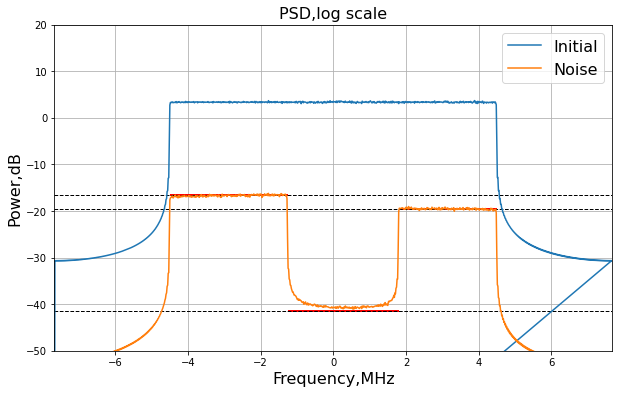

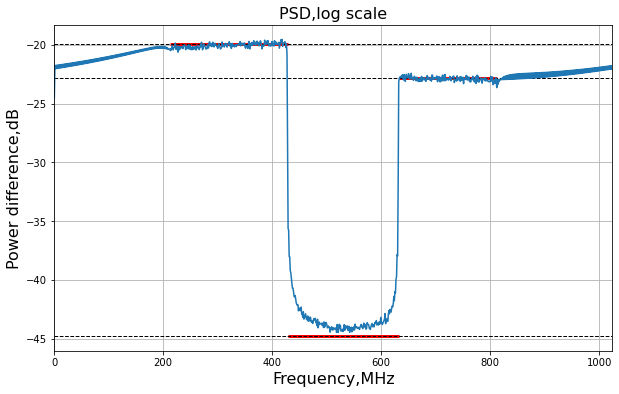

In [154]:
SIGNALS = [S_t,(S_t-S_t_reduced)]
LABELS=['Initial','Noise']
TITLES=['PSD,log scale']
PSD=plots.plot_spectrum(SIGNALS,LABELS,TITLE,ANL_allocation,SC,cfg,PSD_SIZE)

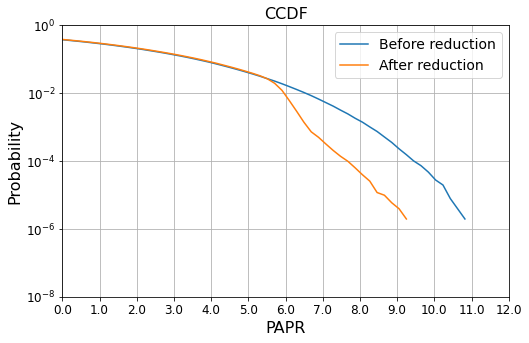

PAPR_mean before reduction tensor(8.6918, device='cuda:0')
PAPR_mean after reduction tensor(6.9024, device='cuda:0')
Mean PAPR has been reduced by:  tensor(1.7895, device='cuda:0')
Max PAPR reduction:  tensor(1.8460, device='cuda:0')


In [155]:
LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDF = [CCDF1,CCDF2]

plots.plot_CCDF(CCDF,LABELS,PAPR_RANGE,figsize=CCDF_SIZE)

PAPR = syst.get_signal_PAPR(S_t_reduced)
PAPR_mean2 = PAPR.mean()
print('PAPR_mean before reduction',PAPR_mean0)
print('PAPR_mean after reduction',PAPR_mean2)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean2)
print('Max PAPR reduction: ',PAPR_max0-PAPR[max_PAPR_idx0])

# Several thresholds

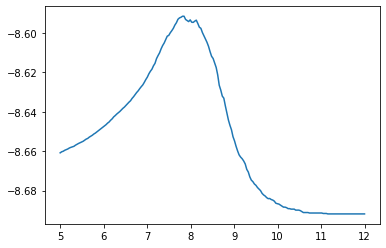

tensor(589, device='cuda:0')


{'mean': 7.814070351758794, 'max': 8.306532663316583}

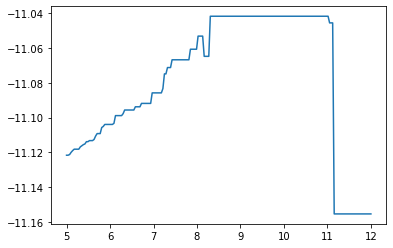

In [156]:
def find_opt_th1(S_t,ue_idx,th_range):
    """
    Finds optimal peak selection threshold for a given signal S_t on subcarriers for given user
    """
    ths = {'mean':0,'max':0}
    res = {'mean':[],'max':[]}

    # find optimum
    for th in th_range:
        peak_th = th
        S_t_reduced = prd.PAPR_reduce(S_t,peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg,info=False)
        PAPR = syst.get_signal_PAPR(S_t_reduced)
        PAPR_mean = PAPR.mean()
        PAPR_max = PAPR.max()
        res['mean'].append(PAPR_mean)
        res['max'].append(PAPR_max)
    ths['mean'] = th_range[np.argmin(res['mean'])]
    ths['max'] = th_range[np.argmin(res['max'])]
    plt.plot(th_range,-np.array(res['mean']))
    plt.show()
    plt.plot(th_range,-np.array(res['max']))
    
    power = torch.abs(S_t)**2
    power_mean = torch.sum(power,axis=0) / 1024
    N = (power >= power_mean.reshape(1,-1)*10**(ths['max']/10)).sum()
    print(N)
    return ths

ue_idx=1
th_range = np.linspace(5,12,200)
th = find_opt_th1(S_t,ue_idx,th_range)
th

In [175]:
def find_opt_th(S_t,ue_idx,th_range):
    """
    Finds optimal peak selection threshold for a given signal S_t on subcarriers for given user
    """
    
    def reduce(S_t,peak_th):
        S_t_reduced = prd.PAPR_reduce(S_t,peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg,info=False)
        PAPR = syst.get_signal_PAPR(S_t_reduced)
        PAPR_mean = PAPR.mean()
        PAPR_max = PAPR.max()
        return PAPR_mean,PAPR_max
        
    ths = {'mean':0,'max':0}
    res = {'mean':[],'max':[]}
    
    bnd1 = np.array([th_range[0],th_range[-1]])
    # find optimum
    for i in range(10):
        mid_point1 = (bnd1[0] + bnd1[1])/2
        mid_res1,_ = reduce(S_t,mid_point1)
        mid_res1e11,_ = reduce(S_t,bnd1[0])
        mid_res1e12,_ = reduce(S_t,bnd1[1])
        edg_res1 = [mid_res1e11,mid_res1e12]
        idx_del1 = np.array([edg_res1[0],edg_res1[1],mid_res1]).argmax()
        bnd1 = np.delete(np.array([bnd1[0],bnd1[1],mid_point1]),idx_del1)
        res['mean'].append(bnd1.mean().item())
    
    for th in th_range:
        peak_th = th
        S_t_reduced = prd.PAPR_reduce(S_t,peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg,info=False)
        PAPR = syst.get_signal_PAPR(S_t_reduced)
        PAPR_mean = PAPR.mean()
        PAPR_max = PAPR.max()
        res['max'].append(PAPR_max)
        
    ths['mean'] = bnd1.mean().item()
    ths['max'] = th_range[torch.argmin(torch.tensor(res['max']))]
    return ths


class function(torch.nn.Module):
    def __init__(self,peak_th,G_group_th,G_SC,S_sc,cfg):
        super(function, self).__init__()
        self.peak_th = peak_th
        self.G_group_th = G_group_th
        self.G_SC = G_SC
        self.S_sc = S_sc
        self.cfg = cfg
        
    def forward(self, S_t):
        S_t_reduced = prd.PAPR_reduce(S_t,self.peak_th,self.G_group_th,self.G_SC,self.S_sc,self.cfg,info=False)
        return S_t_reduced

    def extra_repr(self):
        return 'opt_th={}'.format(self.peak_th)

In [176]:
PERMUTATION = ['direct','random','descending_anl','contribution'][2]
if PERMUTATION == 'direct':
    UE_order = np.arange(cfg['N_UE'])
elif PERMUTATION == 'random':
    UE_order = np.random.permutation(np.arange(cfg['N_UE']))
elif PERMUTATION == 'descending_anl':
    UE_order = ANL_allocation.argsort()[::-1]
elif PERMUTATION == 'contribution':
    UE_order = (RB_allocation*ANL_allocation**0.5).argsort()[::-1]
print('permutation order: ',UE_order)

# create sequential container, add 1st layer
system = nn.Sequential()
# find optimal th for the 1st layer (user)
ue_idx = UE_order[0]
th = find_opt_th(S_t,ue_idx,th_range)
peak_th = th['mean']

power = torch.abs(S_t)**2
power_mean = torch.sum(power,axis=0) / 1024
N = (power >= power_mean.reshape(1,-1)*10**(th['max']/10)).sum()
print('n',N)

system.add_module('layer_'+str(0),function(peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg))

for i in range(1,cfg['N_UE']):
    ue_idx = UE_order[i]
    # find optimal threshold for the 2..end layer (user)
    S_t_reduced = system.forward(S_t)
    th = find_opt_th(S_t_reduced,ue_idx,th_range)
    peak_th = th['mean']
    N = (power >= power_mean.reshape(1,-1)*10**(th['max']/10)).sum()
    print('n',N)
    # add the 2nd..end layer
    system.add_module('layer_'+str(i),function(peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg))
# reduce via the last layer
S_t_reduced = system.forward(S_t)

PAPR = syst.get_signal_PAPR(S_t_reduced)
PAPR_mean1 = PAPR_mean1.mean()
print('Mean PAPR before reduction:',PAPR_mean0)
print('Mean PAPR after reduction:',PAPR_mean1)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean1,'dB')
print('Max PAPR reduction: ',PAPR_max0-PAPR[max_PAPR_idx0],'dB')
system.named_modules

permutation order:  [0 2 1]
n tensor(725, device='cuda:0')
n tensor(1339, device='cuda:0')
n tensor(4624, device='cuda:0')
Mean PAPR before reduction: tensor(8.6918, device='cuda:0')
Mean PAPR after reduction: tensor(6.9024, device='cuda:0')
Mean PAPR has been reduced by:  tensor(1.7895, device='cuda:0') dB
Max PAPR reduction:  tensor(2.0859, device='cuda:0') dB


<bound method Module.named_modules of Sequential(
  (layer_0): function(opt_th=7.18408203125)
  (layer_1): function(opt_th=6.52783203125)
  (layer_2): function(opt_th=6.4287109375)
)>

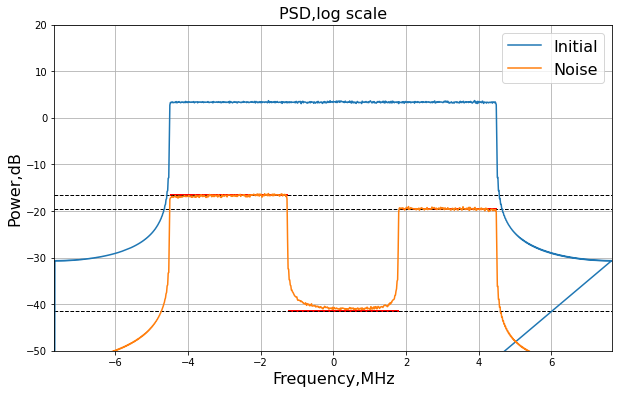

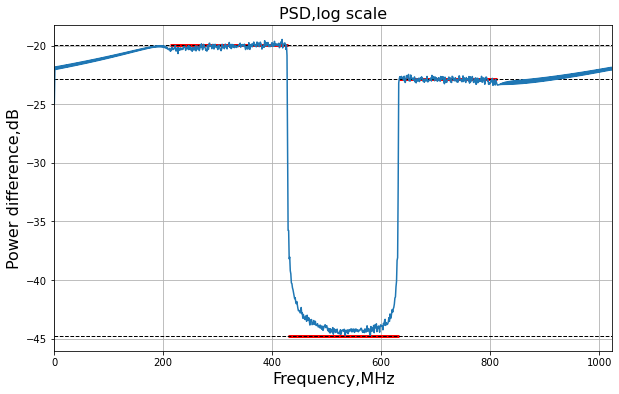

In [177]:
SIGNALS = [S_t,(S_t-S_t_reduced)]
LABELS=['Initial','Noise']
TITLES='PSD,log scale'
PSD=plots.plot_spectrum(SIGNALS,LABELS,TITLE,ANL_allocation,SC,cfg,PSD_SIZE)

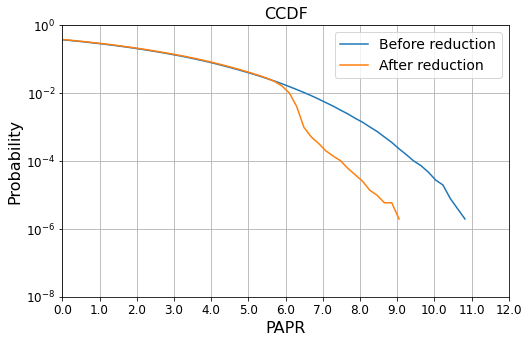

PAPR_mean before reduction tensor(8.6918, device='cuda:0')
PAPR_mean after reduction tensor(6.7880, device='cuda:0')
Mean PAPR has been reduced by:  tensor(1.9038, device='cuda:0')
Max PAPR reduction:  tensor(2.0859, device='cuda:0')


In [178]:
LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDF = [CCDF1,CCDF2]

plots.plot_CCDF(CCDF,LABELS,PAPR_RANGE,figsize=CCDF_SIZE)

PAPR = syst.get_signal_PAPR(S_t_reduced)
PAPR_mean2 = PAPR.mean()
print('PAPR_mean before reduction',PAPR_mean0)
print('PAPR_mean after reduction',PAPR_mean2)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean2)
print('Max PAPR reduction: ',PAPR_max0-PAPR[max_PAPR_idx0])

# One threshold

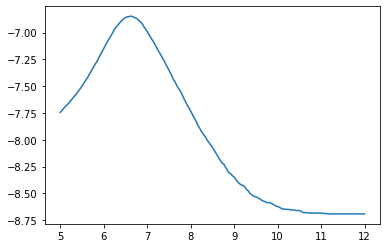

{'mean': 6.618090452261306, 'max': 7.884422110552764}
tensor(1088, device='cuda:0')


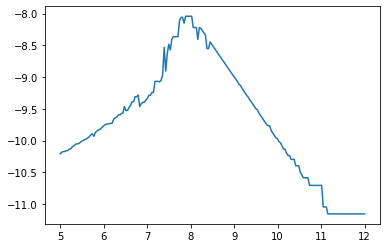

In [179]:
ths = {'mean':0,'max':0}
res = {'mean':[],'max':[]}

for th in th_range:
    peak_th = th
    system = nn.Sequential()
    for i in range(cfg['N_UE']):
        ue_idx = UE_order[i]
        system.add_module('layer_'+str(i),function(peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg))
    S_t_reduced = system.forward(S_t)
    PAPR = syst.get_signal_PAPR(S_t_reduced)
    PAPR_mean = PAPR.mean().item()
    PAPR_max = PAPR.max().item()
    res['mean'].append(PAPR_mean)
    res['max'].append(PAPR_max)
ths['mean'],ths['max'] = th_range[np.argmin(res['mean'])],th_range[np.argmin(res['max'])]
plt.plot(th_range,-np.array(res['mean']))
plt.show()
plt.plot(th_range,-np.array(res['max']))
print(ths)

power = torch.abs(S_t)**2
power_mean = torch.sum(power,axis=0) / 1024
N = (power >= power_mean.reshape(1,-1)*10**(ths['max']/10)).sum()
print(N)

In [181]:
PERMUTATION = ['direct','random','descending_anl','contribution'][1]
if PERMUTATION == 'direct':
    UE_order = np.arange(cfg['N_UE'])
elif PERMUTATION == 'random':
    UE_order = np.random.permutation(np.arange(cfg['N_UE']))
elif PERMUTATION == 'descending_anl':
    UE_order = ANL_allocation.argsort()[::-1]
elif PERMUTATION == 'contribution':
    UE_order = (RB_allocation*ANL_allocation**0.5).argsort()[::-1]
print('permutation order: ',UE_order)

def find_opt_th(S_t,th_range):
    def reduce(S_t,peak_th):
        system = nn.Sequential()
        for i in range(cfg['N_UE']):
            ue_idx = UE_order[i]
            system.add_module('layer_'+str(i),function(peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg))
        S_t_reduced = system.forward(S_t)
        PAPR = syst.get_signal_PAPR(S_t_reduced)
        PAPR_mean = PAPR.mean().item()
        PAPR_max = PAPR.max().item()
        return PAPR_mean,PAPR_max

    ths = {'mean':0,'max':0}
    res = {'mean':[],'max':[]}
    th_range = np.linspace(4,10,201)

    bnd1 = np.array([th_range[0],th_range[-1]])

    for i in range(10):
        # find midddle point
        mid_point1 = (bnd1[0] + bnd1[1])/2
        mid_res1,_ = reduce(S_t,mid_point1)
        mid_res1e11,_ = reduce(S_t,bnd1[0])
        mid_res1e12,_ = reduce(S_t,bnd1[1])
        edg_res1 = [mid_res1e11,mid_res1e12]
        idx_del1 = np.array([edg_res1[0],edg_res1[1],mid_res1]).argmax()
        bnd1 = np.delete(np.array([bnd1[0],bnd1[1],mid_point1]),idx_del1)
        res['mean'].append(bnd1.mean().item())
    
    for th in th_range:
        peak_th = th
        S_t_reduced = prd.PAPR_reduce(S_t,peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg,info=False)
        PAPR = syst.get_signal_PAPR(S_t_reduced)
        PAPR_mean = PAPR.mean()
        PAPR_max = PAPR.max()
        res['max'].append(PAPR_max)
        
    ths['mean'],ths['max'] = bnd1.mean().item(),th_range[torch.argmin(torch.tensor(res['max']))]
    return ths

ths = find_opt_th(S_t,th_range)
print(ths)

power = torch.abs(S_t)**2
power_mean = torch.sum(power,axis=0) / 1024
N = (power >= power_mean.reshape(1,-1)*10**(ths['max']/10)).sum()
print(N)

permutation order:  [1 0 2]
{'mean': 6.5986328125, 'max': 8.29}
tensor(604, device='cuda:0')


In [182]:
peak_th = ths['mean']
system = nn.Sequential()
for i in range(cfg['N_UE']):
    ue_idx = UE_order[i]
    system.add_module('layer_'+str(i),function(peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg))
S_t_reduced = system.forward(S_t)
PAPR = syst.get_signal_PAPR(S_t_reduced)

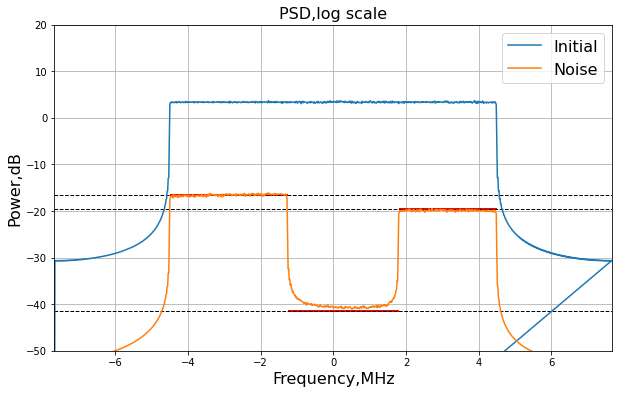

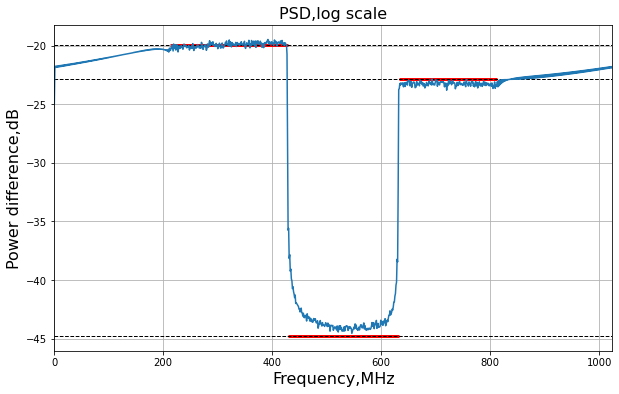

In [183]:
SIGNALS = [S_t,(S_t-S_t_reduced)]
LABELS=['Initial','Noise']
TITLES='PSD,log scale'
PSD=plots.plot_spectrum(SIGNALS,LABELS,TITLE,ANL_allocation,SC,cfg,PSD_SIZE)

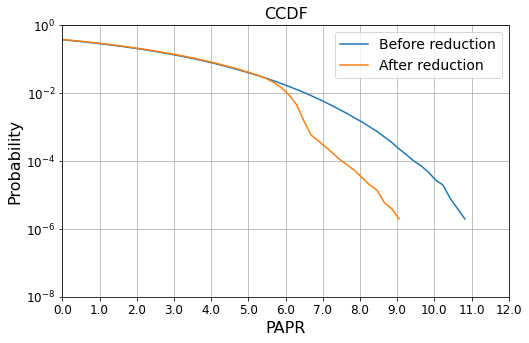

PAPR_mean before reduction tensor(8.6918, device='cuda:0')
PAPR_mean after reduction tensor(6.8859, device='cuda:0')
Mean PAPR has been reduced by:  tensor(1.8059, device='cuda:0')
Max PAPR reduction:  tensor(2.1966, device='cuda:0')


In [184]:
LABELS = ["Before reduction","After reduction"]
CCDF1 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t)
CCDF2 = ccdf.get_CCDF(papr_range=PAPR_RANGE,S_t=S_t_reduced)
CCDF = [CCDF1,CCDF2]

plots.plot_CCDF(CCDF,LABELS,PAPR_RANGE,figsize=CCDF_SIZE)

PAPR = syst.get_signal_PAPR(S_t_reduced)
PAPR_mean2 = PAPR.mean()

print('PAPR_mean before reduction',PAPR_mean0)
print('PAPR_mean after reduction',PAPR_mean2)
print('Mean PAPR has been reduced by: ',PAPR_mean0-PAPR_mean2)
print('Max PAPR reduction: ',PAPR_max0-PAPR[max_PAPR_idx0])

# EXPERIMENT

In [195]:
# OPEN CONFIGURATION FILE
with open('config.yaml','r') as file:
    cfg = yaml.load(file, Loader=yaml.FullLoader)
    print('Config has been readed successfully')

# edit configuration
# cfg['Fs'] = 15.36
cfg['N_UE'] = 2
# cfg['P_UE_max_min'] = 100
# cfg['N_fft'] = 300
# cfg['N_used'] = 120
# cfg['N_zero'] = 180
# cfg['N_RB'] = 10
cfg['M'] = 500
# cfg['N_SC_RB'] = 12

USE_SEED = False
if not USE_SEED:
    cfg['RNG_SEED'] = cfg['P_SEED'] = cfg['M_SEED'] = cfg['RB_SEED'] = None
else:
    cfg['RNG_SEED'], cfg['P_SEED'], cfg['M_SEED'], cfg['RB_SEED'] = 0,1,2,3
# show system's configuration
display(cfg)

# load complex and decimal modulation constellations
constellations = qmd.load_constellations(config=cfg,device=device,info=True)

# load Fourier matrix
S_sc = prd.gen_fourier_matrix(config=cfg,device=device)

# PAPR range for CCDF
PAPR_RANGE = torch.arange(0,12.2,step=0.2)

# zero shift to center spectrum
ZERO_SHIFT = cfg['N_zero']//2

CCDF_SIZE = (8,5)
PSD_SIZE = (10,6)

Config has been readed successfully


{'Fs': 15.36,
 'N_UE': 2,
 'P_UE_max_min': 100,
 'P_TX': 100,
 'N_fft': 1024,
 'N_used': 600,
 'N_zero': 424,
 'N_RB': 50,
 'EVM_QPSK': 17.5,
 'EVM_QAM16': 12.5,
 'EVM_QAM64': 8,
 'EVM_QAM256': 3.5,
 'EVM_QAM1024': 1,
 'M': 500,
 'N_SC_RB': 12,
 'RNG_SEED': None,
 'P_SEED': None,
 'M_SEED': None,
 'RB_SEED': None}

The following constelletions have been loaded: ['QPSK', 'QAM16', 'QAM64', 'QAM256', 'QAM1024']


In [196]:
torch.cuda.ipc_collect()
torch.cuda.empty_cache()
# generate data points
D_points = syst.GEN_points(device,MOD_allocation,RB_allocation,cfg,info=False)
# modulate them
S_t,S_f = syst.MOD_signal(D_points,device,MOD_allocation,PTX_allocation,RB_allocation,constellations,cfg,info=True)
# find mean PAPR
PAPR = syst.get_signal_PAPR(S_t)
PAPR_mean0 = PAPR.mean()
PAPR_max0 = PAPR.max()
max_PAPR_idx0 = torch.argmax(PAPR)
print('Initial mean PAPR is ',PAPR_mean0)
print('Initial max PAPR is ',PAPR_max0,max_PAPR_idx0)

The signal has been generated:
Total power =               66.667
OFDM symbols:                  500
IFFT length:                 1024
Mean power in freq dommain = 12.500
Mean power in time dommain = 12.500
Initial mean PAPR is  tensor(8.6285, device='cuda:0')
Initial max PAPR is  tensor(11.6713, device='cuda:0') tensor(94, device='cuda:0')


In [197]:
# evm_bounds = ((np.array([1,17.5])/100)**2)*(np.array([eps,100-eps])/np.array([eps,100-eps]).sum())
# evm_range = np.linspace(evm_bounds[0],evm_bounds[1],10)

p = 1
rb = 1
evm = 0
PTX_allocation = np.array([p,100-p])
EVM_allocation = np.array([evm,1])
ANL_allocation_P = ((EVM_allocation/100)**2)*(PTX_allocation/PTX_allocation.sum()) 
RB_allocation = np.array([rb,50-rb])
PTX_allocation,EVM_allocation,ANL_allocation_P,RB_allocation

UE_IDXs = np.arange(cfg['N_UE'])
UE_ANLs = ANL_allocation
UE_SCs = [syst.GET_GROUP_SC(N_used=cfg['N_used'],UE_indexes=np.array([i]),RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT for i in UE_IDXs]

In [151]:
from tqdm import tqdm
eps = 1e-6
power_range = np.arange(0,101).astype(float)
power_range[0] += eps
power_range[-1] -= eps
rb_range = np.arange(1,50)
# evm_range = [1,3.5,8,12.5,17.5]
# mod_range = ['QAM1024','QAM256','QAM64', 'QAM16', 'QPSK']
evm_range = [3.5,8,12.5,17.5]
mod_range = ['QAM256','QAM64', 'QAM16', 'QPSK']

performance = np.zeros([len(power_range),len(rb_range),len(evm_range)])

res = {'anl':[],'reduction':[],'rbs':[]}

for i,p in tqdm(enumerate(power_range)):
    for j,rb in enumerate(rb_range):
        for k,(evm,mod) in enumerate(zip(evm_range,mod_range)):
            # setup systems parameters
            PTX_allocation = np.array([p,100-p])
            k = 0
            EVM_allocation = np.array([evm,evm_range[k]])
            MOD_allocation = [mod,mod_range[k]]
            ANL_allocation_P,_ = syst.get_ANL_allocation(EVM_allocation,PTX_allocation,info=False)
            ANL_allocation = ANL_allocation_P
            RB_allocation = np.array([rb,50-rb])
            
            torch.cuda.ipc_collect()
            torch.cuda.empty_cache()
            # generate data points
                # depends on modulation types
                # depends on resourse block allocation
            D_points = syst.GEN_points(device,MOD_allocation,RB_allocation,cfg,info=False)
            # modulate them
                # depends on modulation types
                # depends on power allocation
                # depends on resourse block allocation
            S_t,S_f = syst.MOD_signal(D_points,device,MOD_allocation,PTX_allocation,RB_allocation,constellations,cfg,info=False)
            # find mean PAPR
            PAPR = syst.get_signal_PAPR(S_t)
            PAPR_mean0 = PAPR.mean()
            
            # select group (user)
            ue = 0
            G0_UE_idx = np.array([ue])
            G0_ANL = ANL_allocation[ue]

            # select subcarriers for PAPR reduction
            G0_SC = syst.GET_GROUP_SC(N_used=cfg['N_used'],UE_indexes=G0_UE_idx,RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT
            # generate group threshold
            G0_group_th = G0_ANL
            # choose peak selection thresold
            peak_th = 6.5
            # reduce PAPR
            S_t_reduced = prd.PAPR_reduce(S_t,peak_th,G0_group_th,G0_SC,S_sc,cfg,info=False)
            # find mean PAPR
            PAPR = syst.get_signal_PAPR(S_t_reduced)
            PAPR_mean1 = PAPR.mean()
            reduction = PAPR_mean0 - PAPR_mean1
            performance[i,j,k] = reduction
            
            res['anl'].append(G0_ANL)
            res['reduction'].append(reduction.item())
            res['rbs'].append(rb)
#             print('ggg')
#             break
#         break
#     break
# PTX_allocation,EVM_allocation,ANL_allocation_P,RB_allocation

0it [00:04, ?it/s]


KeyboardInterrupt: 

In [42]:
import h5py
# path = 'performance1'
# with h5py.File(path, 'w') as f:
#     f.create_dataset('anl', data = np.array(res['anl']))
#     f.create_dataset('reduction', data = np.array(res['reduction']))
#     f.create_dataset('rbs', data = np.array(res['rbs']))

path = 'performance'
res1 = {'anl':None,'reduction':None,'rbs':None}
with h5py.File(path, 'r') as f:
    res1['anl'] = f['anl'][:]
    res1['reduction'] = f['reduction'][:]
    res1['rbs'] = f['rbs'][:]

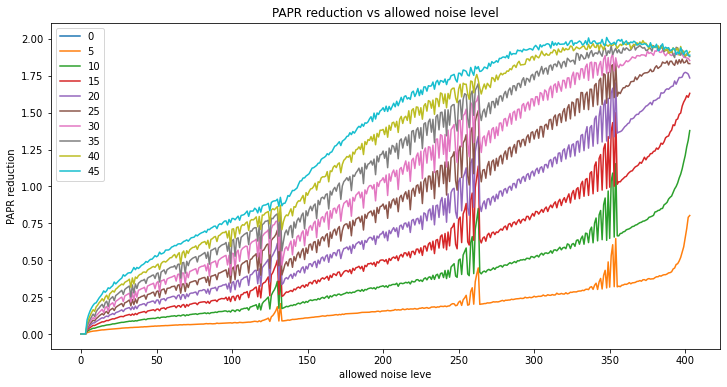

In [43]:
# i-th rb idxs

plt.figure(figsize=(12,6))
plt.title('PAPR reduction vs allowed noise level')
plt.xlabel('allowed noise leve')
plt.ylabel('PAPR reduction')

for i in range(10):
    lst = (res1['rbs'] == i*5)
    idxs = ([i for i, x in enumerate(lst) if x])
    # anl for these idxs
    ordering = res1['anl'][idxs].argsort()
    # reduction for these idxs and ordering
    paprd = res1['reduction'][idxs][ordering]
    plt.plot(paprd,label=str(5*i))
plt.legend()

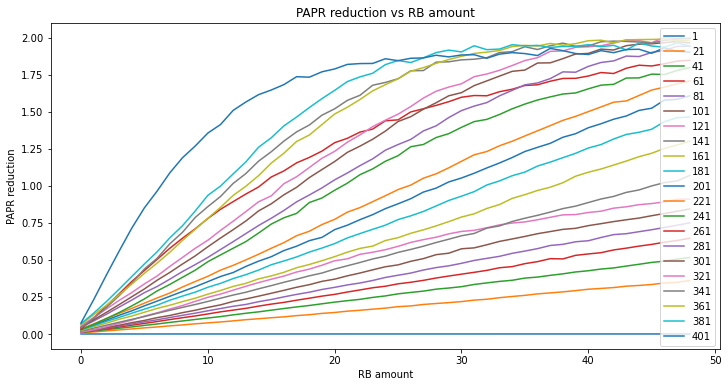

In [44]:
anls = np.sort(res1['anl'])
anls = np.unique(anls)
plt.figure(figsize=(12,6))
plt.title('PAPR reduction vs RB amount')
plt.xlabel('RB amount')
plt.ylabel('PAPR reduction')

for i in range(21):
    lst1 = res1['anl'] == anls[i*20+1]
    idxs1 = ([i for i, x in enumerate(lst1) if x])
    paprd = res1['reduction'][idxs1]
    plt.plot(paprd,label=str(20*i+1))
    
plt.legend()

# UE contribution: approximated and experiimental

$$ C \approx N_{RB} \cdot \sqrt{ANL} $$

* UE power has been allocated - OK:
Max UE power can be:     99.010
Min UE power can be:      0.990
Sum UE power can be:    100.000
Current Ptx allocation: [42. 58.] Sum = 100.000

* MODs have been allocated - OK:
Current MODs allocation: ['QAM64', 'QAM64']
Current EVMs allocation: [8. 8.]

Allowed noise level allocation: [-25.706 -24.304] dB
                                [5.185 6.093] %

* RBs have been allocated - OK:
Current RB allocation: [27 23] Sum = 50

The signal has been generated:
Total power =              100.000
OFDM symbols:                  500
IFFT length:                 1024
Mean power in freq dommain = 28.922
Mean power in time dommain = 28.922
contribution pred [0.9989565 1.       ]
contribution real [0.07882362 1.        ]


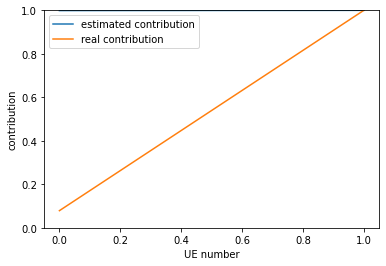

In [45]:
PTX_allocation = syst.PTX_allocate(config=cfg,info=True)
MOD_allocation,EVM_allocation = syst.MOD_allocate(config=cfg,info=True)
ANL_allocation_P,ANL_allocation_A = syst.get_ANL_allocation(EVM_allocation,PTX_allocation,info=True)
ANL_allocation = ANL_allocation_P
RB_allocation = syst.RB_allocate(config=cfg,info=True)

torch.cuda.ipc_collect()
torch.cuda.empty_cache()
# generate data points
D_points = syst.GEN_points(device,MOD_allocation,RB_allocation,cfg,info=False)
# modulate them
S_t,S_f = syst.MOD_signal(D_points,device,MOD_allocation,PTX_allocation,RB_allocation,constellations,cfg,info=True)
# find mean PAPR
PAPR = syst.get_signal_PAPR(S_t)
PAPR_mean0 = PAPR.mean()
PAPR_max0 = PAPR.max()
peak_th = 8

papr_reduction = []
for i in range(cfg['N_UE']):
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    ue_idx = i
    S_t_reduced = prd.PAPR_reduce(S_t,peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg,info=False)
    PAPR = syst.get_signal_PAPR(S_t_reduced)
    PAPR_mean1 = PAPR.mean()
    PAPR_max1 = PAPR.max()
    papr_reduction.append((PAPR_mean0-PAPR_mean1).cpu().item())

contribution_predicted = RB_allocation * ANL_allocation**0.5 / max(RB_allocation * ANL_allocation**0.5)
print('contribution pred',contribution_predicted)
contribution_real = papr_reduction/np.array(papr_reduction).max()
print('contribution real',contribution_real)

plt.ylim(0,1)
plt.plot(contribution_predicted,label='estimated contribution')
plt.plot(contribution_real,label='real contribution')
plt.xlabel('UE number')
plt.ylabel('contribution')
plt.legend()

In [46]:
import pandas as pd

df0 = pd.DataFrame(columns=['N_UE','PTX_Alloc','RB_Alloc','MOD_Alloc','MOD_Alloc_n','ANL_Alloc','OPT_th_mean','OPT_th_max'])

for i in range(10):
#     perm = np.random.permutation(np.arange(3))
    
    PTX_allocation = syst.PTX_allocate(config=cfg,info=False)
#     PTX_allocation = PTX_allocation = 100*np.ones(cfg['N_UE'])/cfg['N_UE']
#     PTX_allocation = np.array([20,30,50])[perm]
    MOD_allocation,EVM_allocation = syst.MOD_allocate(config=cfg,info=False)
    mod_list = ['QPSK','QAM16','QAM64', 'QAM256','QAM1024']
    idxs = []
    for item in MOD_allocation:
        idx = np.argmax(np.array(mod_list) == item)
        idxs.append(idx)
    MOD_allocation_n = np.array(idxs)
#     MOD_allocation = []
#     for i in range(3): MOD_allocation.append(['QAM256', 'QAM1024', 'QAM16'][perm[i]])
#     EVM_allocation = np.array([8,1,12.5])[perm]
    ANL_allocation_P,ANL_allocation_A = syst.get_ANL_allocation(EVM_allocation,PTX_allocation,info=False)
    ANL_allocation = ANL_allocation_P
    RB_allocation = syst.RB_allocate(config=cfg,info=False)
#     RB_allocation = np.array([16,16,18])[perm]


    UE_IDXs = np.arange(cfg['N_UE'])
    UE_ANLs = ANL_allocation
    UE_SCs = [syst.GET_GROUP_SC(N_used=cfg['N_used'],UE_indexes=np.array([i]),RB_allocation=torch.tensor(RB_allocation)) + ZERO_SHIFT for i in UE_IDXs]

    torch.cuda.ipc_collect()
    torch.cuda.empty_cache()
    # generate data points
    D_points = syst.GEN_points(device,MOD_allocation,RB_allocation,cfg,info=False)
    # modulate them
    S_t,S_f = syst.MOD_signal(D_points,device,MOD_allocation,PTX_allocation,RB_allocation,constellations,cfg,info=False)
    # find mean PAPR
    PAPR = syst.get_signal_PAPR(S_t)
    PAPR_mean0 = PAPR.mean()
    PAPR_max0 = PAPR.max()

    PERMUTATION = ['direct','random','descending_anl','contribution'][2]
    if PERMUTATION == 'direct':
        UE_order = np.arange(cfg['N_UE'])
    elif PERMUTATION == 'random':
        UE_order = np.random.permutation(UE_order)
    elif PERMUTATION == 'descending_anl':
        UE_order = ANL_allocation.argsort()[::-1]
    elif PERMUTATION == 'contribution':
        UE_order = (RB_allocation*ANL_allocation**0.5).argsort()[::-1]
    print('permutation order: ',UE_order)

    ths = {'mean':0,'max':0}
    res = {'mean':[],'max':[]}
    th_range = np.linspace(6,10,201)

    for th in th_range:
        peak_th = th
        system = nn.Sequential()
        for i in range(cfg['N_UE']):
            ue_idx = UE_order[i]
            system.add_module('layer_'+str(i),function(peak_th,UE_ANLs[ue_idx],UE_SCs[ue_idx],S_sc,cfg))
        S_t_reduced = system.forward(S_t)
        PAPR = syst.get_signal_PAPR(S_t_reduced)
        PAPR_mean = PAPR.mean().item()
        PAPR_max = PAPR.max().item()
        res['mean'].append(PAPR_mean)
        res['max'].append(PAPR_max)
    ths['mean'],ths['max'] = th_range[np.argmin(res['mean'])],th_range[np.argmin(res['max'])]

    params_dict = {'N_UE':3,
                   'PTX_Alloc': PTX_allocation,
                   'RB_Alloc': RB_allocation,
                   'MOD_Alloc': MOD_allocation,
                   'MOD_Alloc_n': MOD_allocation_n,
                   'ANL_Alloc': ANL_allocation,
                   'OPT_th_mean': ths['mean'],
                   'OPT_th_max': ths['max']}
    df0 = df0.append(params_dict,ignore_index=True)

df0

permutation order:  [0 1]
permutation order:  [0 1]
permutation order:  [1 0]
permutation order:  [1 0]
permutation order:  [0 1]
permutation order:  [0 1]
permutation order:  [1 0]
permutation order:  [1 0]
permutation order:  [0 1]
permutation order:  [0 1]


,N_UE,PTX_Alloc,RB_Alloc,MOD_Alloc,MOD_Alloc_n,ANL_Alloc,OPT_th_mean,OPT_th_max
0,3,"[68.0, 32.0]","[29, 21]","[QAM16, QAM64]","[1, 2]","[0.010625, 0.0020480000000000003]",6.30,7.36
1,3,"[29.0, 71.0]","[22, 28]","[QPSK, QAM1024]","[0, 4]","[0.008881249999999999, 7.1e-05]",6.86,7.70
2,3,"[49.0, 51.0]","[30, 20]","[QPSK, QPSK]","[0, 0]","[0.015006249999999997, 0.015618749999999999]",6.00,6.34
3,3,"[50.0, 50.0]","[21, 29]","[QAM16, QAM16]","[1, 1]","[0.0078125, 0.0078125]",6.18,7.18
4,3,"[61.0, 39.0]","[20, 30]","[QAM256, QAM256]","[3, 3]","[0.0007472500000000001, 0.0004777500000000001]",7.26,7.36
5,3,"[64.0, 36.0]","[12, 38]","[QPSK, QPSK]","[0, 0]","[0.0196, 0.011024999999999998]",6.00,7.12
6,3,"[59.0, 41.0]","[26, 24]","[QAM1024, QAM64]","[4, 2]","[5.9e-05, 0.002624]",7.26,8.92
7,3,"[68.0, 32.0]","[24, 26]","[QAM256, QAM16]","[3, 1]","[0.0008330000000000002, 0.005]",6.78,8.36
8,3,"[60.0, 40.0]","[18, 32]","[QAM16, QAM16]","[1, 1]","[0.009375, 0.00625]",6.24,7.24
9,3,"[78.0, 22.0]","[15, 35]","[QPSK, QPSK]","[0, 0]","[0.0238875, 0.0067374999999999996]",6.00,6.96


In [402]:
X = df0[[
#          'N_UE',
         'PTX_Alloc',
         'RB_Alloc',
#          'MOD_Alloc',
         'MOD_Alloc_n',
#          'ANL_Alloc',
         'OPT_th_mean',
         'OPT_th_max']]

y = df0['OPT_th_mean']
X

,PTX_Alloc,RB_Alloc,MOD_Alloc_n,OPT_th_mean,OPT_th_max
0,"[37.0, 19.0, 44.0]","[14, 15, 21]","[0, 0, 0]",6.00,7.26
1,"[12.0, 26.0, 62.0]","[19, 19, 12]","[1, 0, 1]",6.30,7.02
2,"[45.0, 47.0, 8.0]","[15, 21, 14]","[1, 4, 1]",6.88,8.70
3,"[33.0, 53.0, 14.0]","[12, 18, 20]","[4, 4, 2]",7.42,9.68
4,"[42.0, 12.0, 46.0]","[21, 10, 19]","[2, 1, 4]",7.08,8.80
5,"[36.0, 18.0, 46.0]","[14, 18, 18]","[4, 1, 1]",6.72,8.28
6,"[39.0, 41.0, 20.0]","[17, 17, 16]","[0, 2, 4]",6.64,8.22
7,"[36.0, 36.0, 28.0]","[9, 24, 17]","[0, 0, 2]",6.12,7.74
8,"[39.0, 44.0, 17.0]","[19, 12, 19]","[3, 0, 4]",7.10,8.62
9,"[26.0, 59.0, 15.0]","[27, 11, 12]","[2, 4, 4]",7.40,8.46


In [403]:
X

,PTX_Alloc,RB_Alloc,MOD_Alloc_n,OPT_th_mean,OPT_th_max
0,"[37.0, 19.0, 44.0]","[14, 15, 21]","[0, 0, 0]",6.00,7.26
1,"[12.0, 26.0, 62.0]","[19, 19, 12]","[1, 0, 1]",6.30,7.02
2,"[45.0, 47.0, 8.0]","[15, 21, 14]","[1, 4, 1]",6.88,8.70
3,"[33.0, 53.0, 14.0]","[12, 18, 20]","[4, 4, 2]",7.42,9.68
4,"[42.0, 12.0, 46.0]","[21, 10, 19]","[2, 1, 4]",7.08,8.80
5,"[36.0, 18.0, 46.0]","[14, 18, 18]","[4, 1, 1]",6.72,8.28
6,"[39.0, 41.0, 20.0]","[17, 17, 16]","[0, 2, 4]",6.64,8.22
7,"[36.0, 36.0, 28.0]","[9, 24, 17]","[0, 0, 2]",6.12,7.74
8,"[39.0, 44.0, 17.0]","[19, 12, 19]","[3, 0, 4]",7.10,8.62
9,"[26.0, 59.0, 15.0]","[27, 11, 12]","[2, 4, 4]",7.40,8.46


In [404]:
y

0    6.00
1    6.30
2    6.88
3    7.42
4    7.08
5    6.72
6    6.64
7    6.12
8    7.10
9    7.40
Name: OPT_th_mean, dtype: float64

In [448]:
# encoding table
qpsk = np.array([1,0,0,0,0])
qam16 = np.array([0,1,0,0,0])
qam64 = np.array([0,0,1,0,0])
qam256 = np.array([0,0,0,1,0])
qam1024 = np.array([0,0,0,0,1])

def encode_modulation(item):
    out = []
    for i in item:
        if i == 0:
            out.append(qpsk)
        elif i == 1:
            out.append(qam16)
        elif i == 2:
            out.append(qam64)
        elif i == 3:
            out.append(qam256)
        elif i == 4:
            out.append(qam1024)
    return np.array(out)

encode_modulation(np.array([1,0,2]))

array([[0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]])

In [447]:
np.array(X['MOD_Alloc_n'])

array([array([0, 0, 0]), array([1, 0, 1]), array([1, 4, 1]),
       array([4, 4, 2]), array([2, 1, 4]), array([4, 1, 1]),
       array([0, 2, 4]), array([0, 0, 2]), array([3, 0, 4]),
       array([2, 4, 4])], dtype=object)

In [405]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
encoded_features = pd.DataFrame(ohe.fit_transform(X['MOD_Alloc_n']))
encoded_features

ValueError: Expected 2D array, got 1D array instead:
array=[array([0, 0, 0]) array([1, 0, 1]) array([1, 4, 1]) array([4, 4, 2])
 array([2, 1, 4]) array([4, 1, 1]) array([0, 2, 4]) array([0, 0, 2])
 array([3, 0, 4]) array([2, 4, 4])].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

tensor([[0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j,  ...,
         0.0000+-0.0000j, 0.0000+0.0000j, 0.0000+0.0000j],
        [0.0000+0.0000j, 0.0000+0.0000j, -0.0000+0.0000j,  ...,
         0.0000+-0.0000j, 0.0000+0.0000j, 0.0000+-0.0000j],
        [0.0000+-0.0000j, -0.0000+0.0000j, -0.0000+0.0000j,  ...,
         -0.0000+0.0000j, -0.0000+0.0000j, 0.0000+-0.0000j],
        ...,
        [-0.0000+0.0000j, 0.0000+0.0000j, 0.0000+-0.0000j,  ...,
         0.0000+-0.0000j, 0.0000+0.0000j, -0.0000+0.0000j],
        [0.0000+0.0000j, -0.0000+0.0000j, -0.0000+0.0000j,  ...,
         -0.0000+0.0000j, 0.0000+0.0000j, 0.0000+-0.0000j],
        [0.0000+-0.0000j, -0.0000+0.0000j, 0.0000+0.0000j,  ...,
         7.1076+10.0047j, 0.0000+-0.0000j, 0.0000+0.0000j]], device='cuda:0')